In [4]:
#Load packages
from netCDF4 import Dataset
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import sys
import netCDF4 as nc4

sys.path.append("/home2/datahome/tpicard/python/Python_Modules_p3_pyticles/")

from Modules import *
from Modules_gula import *
import torch
from torch.utils.data import DataLoader, Dataset


In [5]:
# Read the data for a given period

def read_data(dt):
    datetime=dt*101
    nc = nc4.Dataset('/home2/datawork/tpicard/Pyticles/CNN_DATA/trainning_database_{0:06}.nc'.format(datetime),'r')
    inputs = np.nan_to_num(np.asfortranarray(nc.variables['inputs']))
    inputs= np.transpose(inputs, axes=[0,3,1,2])
    outputs = np.nan_to_num(np.asfortranarray(nc.variables['outputs'])*100) #Pour avoir une somme = 1
    outputs= np.transpose(outputs, axes=[0,3,1,2])
    nc.close()
    return(inputs,outputs)

# Return a set of trainning and test data

def train_test_data():
    dt_start = 10
    dt_end = 15
    
    pdf_train = np.zeros((90*(dt_end-dt_start),1,80,80))
    pdf_test = np.zeros((18*(dt_end-dt_start),1,80,80))
    image_train = np.zeros((90*(dt_end-dt_start),52,400,400))
    image_test = np.zeros((18*(dt_end-dt_start),52,400,400))
    i=0
    for dt in range(dt_start,dt_end,1):
        inputs,outputs = read_data(dt)
        image_train[i*90:(i+1)*90,:,:,:] = inputs[:90,:,:,:]
        pdf_train[i*90:(i+1)*90,:,:,:] = outputs[:90,:,:,:]

        image_test[i*18:(i+1)*18,:,:,:] = inputs[90:,:,:,:]
        pdf_test[i*18:(i+1)*18,:,:,:] = outputs[90:,:,:,:]
        i =i+1
        
    return(image_train,pdf_train,image_test,pdf_test)


In [6]:
class Pdf_Image_DataSet(Dataset):
    def __init__(self,images, pdf,transform=None):
        
        self.pdf = pdf
        self.images = images
        self.transform = transform

    def __len__(self):
        return self.pdf.shape[0]

    def __getitem__(self, idx):
        # select coordinates
        pdf_sample = self.pdf[idx,:,:,:]
        image_sample = self.images[idx,:,:,:]
        
        if self.transform:
            pdf_sample = self.transform(pdf_sample)
            image_sample = self.transform(image_sample)
            
        return image_sample, pdf_sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        return torch.FloatTensor(sample)

In [7]:
from torch import nn
from torch import optim
import progressbar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
# hyperparameters
batch_size = 30

(train_images,train_pdf,test_images,test_pdf) = train_test_data()

## reduce size dataset
train_set = Pdf_Image_DataSet(train_images,train_pdf,transform= ToTensor())
#train_set.device()
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

test_set = Pdf_Image_DataSet(test_images,test_pdf,transform= ToTensor())
#test_set.device()
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

In [9]:
# Check the shape of inputs and outputs

for X, y in test_loader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([30, 52, 400, 400])
Shape of y:  torch.Size([30, 1, 80, 80]) torch.float32


In [10]:
from torch import nn
from torch import optim
import progressbar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# Achitecture of the model 

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.Conv2d(52, 26, kernel_size = 1, padding = 0),
            nn.ReLU(True),

            nn.AvgPool2d(5),

            nn.Conv2d(26, 1, kernel_size = 1, padding = 0),
            
            nn.Flatten(start_dim=1, end_dim=- 1), # image 80x80 to a vector
            nn.Softmax(dim=1), 
         )
    def forward(self, z):    
        out = self.cnn(z)
        #print(out.shape)
        out = out.view(out.shape[0],1,80,80)
        return out

In [22]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    #elif classname.find('AvgPool2d') != -1:
    #    nn.init.normal_(m.weight.data, 1.0, 0.02)
    #    nn.init.constant_(m.bias.data, 0)

In [23]:
# create network
model = CNN().to(device)

# weight initialization
model = model.apply(weights_init)

lambda_loss=10000
# define loss and optimizers
loss_fn = nn.MSELoss()
lr = 0.02
optimizer = optim.Adam(model.parameters(),lr= lr, betas=(0.5, 0.999))

In [24]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss=0
    loss_coeff = 1e6
    for batch, (X, y) in enumerate(dataloader):
        
        # TRAIN MODEL
        model.zero_grad()
        pred = model(X)
        loss = loss_coeff*loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(loss)
        
    if epoch%10 == 0:
        print('\nEpoch [{}/{}] -----------------------------------------------------------------------------'
            .format(epoch+1, nb_epoch))

    if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    return(pred,loss)

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    loss_coeff = 1e6
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            #print(loss_fn(pred, y))
            test_loss += loss_coeff*loss_fn(pred, y).item()
            #print(test_loss)
    
    #test_loss /= num_batches
    print(f"Test Error: Avg loss: {test_loss:>8f} \n") 
    return(pred,test_loss)

 10% (1 of 10) |##                       | Elapsed Time: 0:01:21 ETA:   0:12:14

Test Error: Avg loss: 18.795037 



 20% (2 of 10) |#####                    | Elapsed Time: 0:02:43 ETA:   0:10:53

Test Error: Avg loss: 18.803838 



 30% (3 of 10) |#######                  | Elapsed Time: 0:04:05 ETA:   0:09:33

Test Error: Avg loss: 18.801766 



 40% (4 of 10) |##########               | Elapsed Time: 0:05:26 ETA:   0:08:09

Test Error: Avg loss: 18.806022 



 50% (5 of 10) |############             | Elapsed Time: 0:06:48 ETA:   0:06:49

Test Error: Avg loss: 18.802287 



 60% (6 of 10) |###############          | Elapsed Time: 0:08:10 ETA:   0:05:26

Test Error: Avg loss: 18.810390 



 70% (7 of 10) |#################        | Elapsed Time: 0:09:32 ETA:   0:04:05

Test Error: Avg loss: 18.802077 



 80% (8 of 10) |####################     | Elapsed Time: 0:10:53 ETA:   0:02:42

Test Error: Avg loss: 18.799848 



 90% (9 of 10) |######################   | Elapsed Time: 0:12:14 ETA:   0:01:21

Test Error: Avg loss: 18.801681 


Epoch [11/10] -----------------------------------------------------------------------------


100% (10 of 10) |########################| Elapsed Time: 0:13:36 Time:  0:13:36


Test Error: Avg loss: 18.800381 



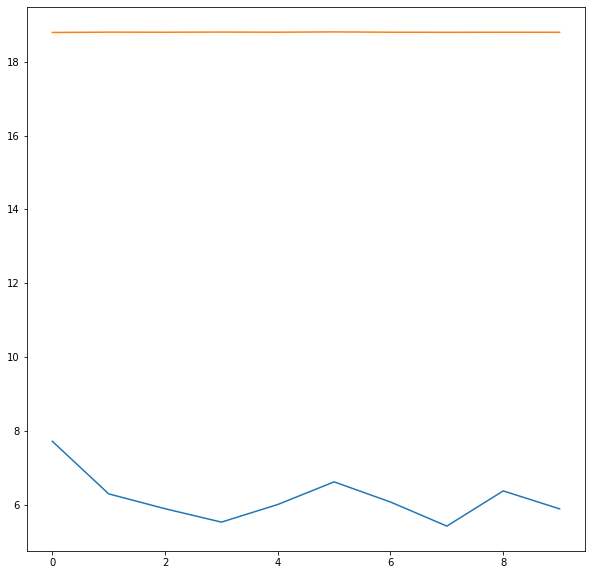

In [25]:
# Train the model
nb_epoch = 10
epoch = 0
loss_train_list=[]
loss_test_list=[]

for i in progressbar.progressbar(range(nb_epoch)):
    epoch +=1
    (pred,loss) = train_loop(train_loader, model, loss_fn, optimizer)
    loss_train_list.append(loss)
    (pred,loss)= test_loop(test_loader, model, loss_fn)   
    loss_test_list.append(loss)
    
plt.figure(figsize =(10,10))
plt.plot(loss_train_list)
plt.plot(loss_test_list)
plt.grid()

In [26]:
pred[2,0,:,:]

tensor([[2.0155e-04, 1.9947e-04, 2.1248e-04,  ..., 2.0952e-05, 1.8668e-05,
         1.8148e-05],
        [2.2690e-04, 2.2953e-04, 2.4034e-04,  ..., 2.3155e-05, 1.9408e-05,
         1.8724e-05],
        [2.2910e-04, 2.4555e-04, 2.5433e-04,  ..., 2.5114e-05, 2.1576e-05,
         2.0817e-05],
        ...,
        [2.6131e-04, 2.8002e-04, 3.2289e-04,  ..., 3.3681e-06, 3.3622e-06,
         3.3583e-06],
        [2.8642e-04, 2.9428e-04, 2.9141e-04,  ..., 3.3684e-06, 3.3640e-06,
         3.3626e-06],
        [2.4749e-04, 2.3652e-04, 2.4018e-04,  ..., 3.3718e-06, 3.3686e-06,
         3.3683e-06]])

In [26]:
torch.sum(pred[0,:,:])

tensor(1.0000)

# Visual test on the last prediction

<ipython-input-32-0b7307d3107f>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,y,pred[5,0,:,:].detach().numpy())


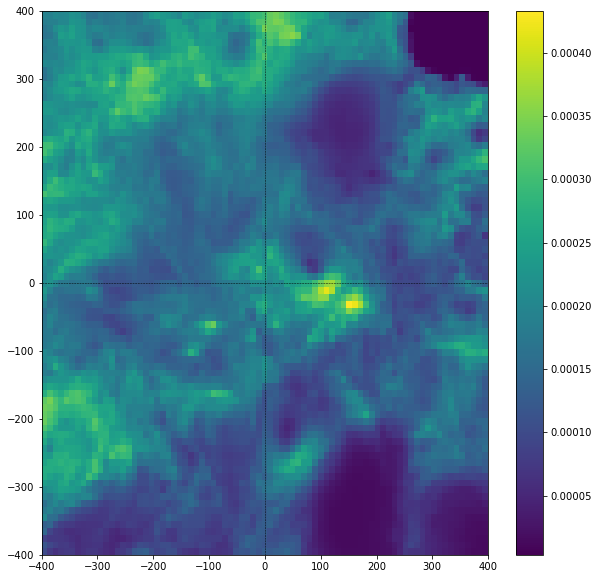

In [32]:
#xband, yband = np.linspace(-800,800,160), np.linspace(-800,800,160)
xband, yband = np.linspace(-400,400,81), np.linspace(-400,400,81)

fig = plt.figure(figsize=(10,10))

cmap = 'Spectral_r'
levels=np.logspace(-5, -4, 10)
norm= colors.LogNorm(vmin=1e-5, vmax=1e-4)

ax = ax = fig.add_subplot(1,1,1)
#cb.set_ticks([1e-6, 1e-5, 1e-4])
#cb.ax.tick_params(labelsize='large')
ax.set_xlim([-400,400])
ax.set_ylim([-400,400])
x = np.linspace(-400,400,80)
y = np.linspace(-400,400,80)
plt.pcolormesh(x,y,pred[5,0,:,:].detach().numpy())
plt.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
plt.axhline(y=0,color='black',linestyle='--',linewidth=0.5)
plt.colorbar()
#ctf = ax.contourf(0.5*(xband[:-1]+xband[1:]), 0.5*(yband[:-1]+yband[1:]), pred[0,0,:,:].T,  levels, norm=norm, cmap=cmap, extend='both',alpha=0.2)
